In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.externals import joblib
import cv2
from scipy.cluster.vq import vq, kmeans
from matplotlib import pyplot as plt
import numpy as np
import time as t
import os
import math

In [3]:
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(30,30), ratio=1, conv_color = False):
    
    if conv_color:
        list_of_images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in list_of_images]
    
    num_img = len(list_of_images)
    row = math.ceil( num_img / no_of_columns )
    
    if figsize[1] == 0:
        fig = plt.figure(figsize=(figsize[0], figsize[0]*row/no_of_columns/ratio))
    else:
        fig = plt.figure(figsize=figsize)
    
    for i, img in enumerate(list_of_images):
        fig.add_subplot( row, no_of_columns , i+1)
        plt.imshow(list_of_images[i])
        plt.axis('off')
    plt.show()
        

In [4]:
# set target organ
target_organ = 'neck'

organ_dirs = {'jaw':'./jaw/', 
              'cheek_l':'./cheek_l/', 
              'cheek_r':'./cheek_r/', 
              'nose':'./nose/', 
              'lip':'./lip/', 
              'forehead':'./forehead/', 
              'neck':'./neck/'
             }

file_paths = {}
for key in organ_dirs:
    file_paths[key] = []
    for file_name in os.listdir(organ_dirs[key]):
        file_paths[key].append(organ_dirs[key] + file_name)

print (file_paths[target_organ][0])


./neck/m-041-01.jpg


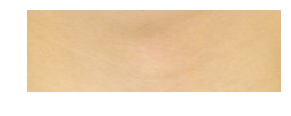

In [5]:
target_image = file_paths[target_organ][0]
img = cv2.imread(target_image)
# img[:,:,0] = np.zeros(img[:,:,1].shape)
# img[:,:,1] = np.zeros(img[:,:,2].shape)

# Img2Grey
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Grey2Binary
ret, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
# detect contour
_, contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
# draw contour
# cv2.drawContours(image, contours, contourIdx, color[, thickness[, lineType[, hierarchy[, maxLevel[, offset ]]]]])
# cv2.drawContours(img, contours, 1, (0, 0, 255), 1)
images = [ img ]    
grid_display(images, contours, 2, (10,10), 2, conv_color = True)


### Use HSV space feature

In [6]:
hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hue, sat, val = hsv_image[:,:,0], hsv_image[:,:,1], hsv_image[:,:,2]

# plt.figure(figsize=(10,8))
# plt.subplot(311)                             #plot in the first cell
# plt.subplots_adjust(hspace=.5)
# plt.title("Hue")
# plt.hist(np.ndarray.flatten(hue), bins=235)
# plt.subplot(312)                             #plot in the second cell
# plt.title("Saturation")
# plt.hist(np.ndarray.flatten(sat), bins=200)
# plt.subplot(313)                             #plot in the third cell
# plt.title("Luminosity Value")
# plt.hist(np.ndarray.flatten(val), bins=200)
# plt.show()

In [7]:
#set feature dimension, e.g.  histogram bin number
dim_h = 180
dim_s = 256
dim_v = 256
hsv_data = np.zeros( ( len(file_paths[target_organ]), dim_h+dim_s+dim_v  ) )

for i, target_organ_path in enumerate( file_paths[target_organ] ):
    img = cv2.imread(target_organ_path)
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # hue(色调): 0-180
    # Saturation(饱和度): 0-255
    # Value(亮度): 0-255
    hue, sat, val = hsv_image[:,:,0], hsv_image[:,:,1], hsv_image[:,:,2]
    # minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(val)
    # print('maxval: {}, minval:{}'.format(maxVal, minVal))
    hist_hue = cv2.calcHist([hsv_image], [0], None, [dim_h], [0, 180])
    hist_sat = cv2.calcHist([hsv_image], [1], None, [dim_s], [0, 256])
    hist_val = cv2.calcHist([hsv_image], [2], None, [dim_v], [0, 256])

    hsv_data[i] = np.ndarray.flatten(np.concatenate([hist_hue, hist_sat, hist_val]))

    
hsv_data.dump('./hsv_data.np')
hsv_data2 = np.load('./hsv_data.np')
print (hsv_data.shape)


(188, 692)


### Use RGB space feature

In [226]:
dim = 256

# hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
blue, green, red = img[:,:,0], img[:,:,1], img[:,:,2]
print (img.shape)
hist_b = cv2.calcHist([img], [0], None, [dim], [0, 256])
hist_g = cv2.calcHist([img], [1], None, [dim], [0, 256])
hist_r = cv2.calcHist([img], [2], None, [dim], [0, 256])

# plt.figure(figsize=(10,8))
# plt.subplot(311)                             #plot in the first cell
# plt.subplots_adjust(hspace=.5)
# plt.title("blue")
# plt.bar(range(dim), hist_b, color = 'b')
# plt.subplot(312)                             #plot in the second cell
# plt.title("green")
# plt.bar(range(dim), hist_g, color = 'g')
# plt.subplot(313)                             #plot in the third cell
# plt.title("red")
# plt.bar(range(dim), hist_r, color = 'r')
# plt.show()

# plt.figure(figsize=(10,8))
# plt.subplot(311)                             #plot in the first cell
# plt.subplots_adjust(hspace=.5)
# plt.title("blue")
# plt.hist(np.ndarray.flatten(blue), bins=128)
# plt.subplot(312)                             #plot in the second cell
# plt.title("green")
# plt.hist(np.ndarray.flatten(green), bins=128)
# plt.subplot(313)                             #plot in the third cell
# plt.title("red")
# plt.hist(np.ndarray.flatten(red), bins=128)
# plt.show()

(71, 221, 3)


In [220]:
print (hist_g.shape)
print (np.ndarray.flatten(hist_b).shape)
concat_bgr = []
concat_bgr = np.concatenate([hist_b, hist_g, hist_r])
print (concat_bgr.shape)


(256, 1)
(256,)
(768, 1)


In [227]:
bgr_data = np.zeros( ( len(file_paths[target_organ]), dim*3  ) )
for i, target_organ_path in enumerate( file_paths[target_organ] ):
    img = cv2.imread(target_organ_path)
    blue, green, red = img[:,:,0], img[:,:,1], img[:,:,2]
    # normailize
#     img[:,:,0] = blue/256
#     img[:,:,1] = green/256
#     img[:,:,2] = red/256
    hist_b = cv2.calcHist([img], [0], None, [dim], [0, 256])
    hist_g = cv2.calcHist([img], [1], None, [dim], [0, 256])
    hist_r = cv2.calcHist([img], [2], None, [dim], [0, 256])
    
    bgr_data[i] = np.ndarray.flatten(np.concatenate([hist_b, hist_g, hist_r]))
#     print (bgr_data[i][:10])

bgr_data.dump('./bgr_data.np')
bgr_data2 = np.load('./bgr_data.np')
print (bgr_data.shape)


(188, 768)


### Kmeans Clustering

In [8]:
#https://blog.csdn.net/EleanorWiser/article/details/70226704

#set cluster number
cluster_num = 5

# cluster_data = bgr_data
cluster_data = hsv_data
#use kmeans to cluster
clf = KMeans(n_clusters=cluster_num)
s = clf.fit(cluster_data)
print (s)
print (cluster_data.shape)

# #show center value
# print (clf.cluster_centers_)

# #show clusters
# print (clf.labels_)

# inertia_: Sum of squared distances of samples to their closest cluster center
# evaluate cluster inertia is good or not
# the value is better to be smaller, try different k and use the best one
print (clf.inertia_)

#predict
cluster_pred = clf.predict(cluster_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
(188, 692)
2748698703.55


2748698703.55
cluster: 0


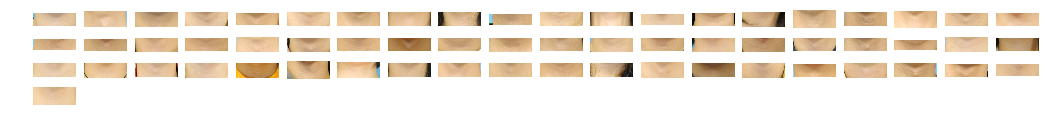

cluster: 1


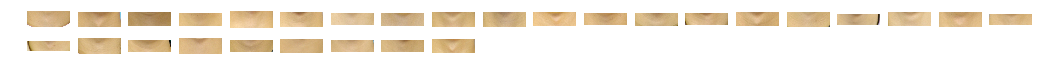

cluster: 2


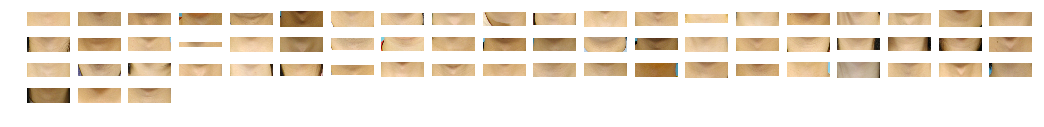

cluster: 3


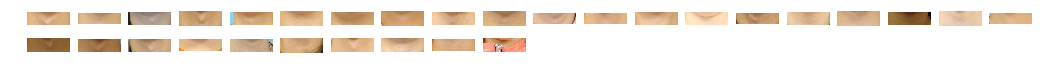

cluster: 4


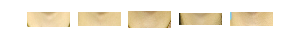

In [9]:
#store cluster result
clustered_imgs = {i:[] for i in range(cluster_num)}

for i, label in enumerate(cluster_pred):
    clustered_imgs[label].append( cv2.imread(file_paths[target_organ][i]) ) 

print (clf.inertia_)
    
for key in clustered_imgs:
    print ('cluster: {}'.format(key))
    grid_display(clustered_imgs[key], [], 20, (18,0), 2, conv_color = True)
    


In [ ]:

#保存模型
joblib.dump(clf , 'c:/km.pkl')

#载入保存的模型
clf = joblib.load('c:/km.pkl')

'''
#用来评估簇的个数是否合适，距离越小说明簇分的越好，选取临界点的簇个数
for i in range(5,30,1):
    clf = KMeans(n_clusters=i)
    s = clf.fit(feature)
    print i , clf.inertia_
'''